In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Passata di preprocessing, alcuni valori hanno solo un dato di anomalous settato.

In [4]:
df = pd.read_csv("dati_preprocessati.csv")

anomalous = 0
index = 0

for row in df.itertuples():
  # creo dataframe di appoggio con il giorno selezionato
  index = row[1]

  df_aux = df[df["Index"] == row[1]]

  for row_aux in df_aux.itertuples():
    if row_aux[3] == 1:
      anomalous = 1
    if anomalous == 1:
      df.loc[row[0],"Anomalous"] = 1

  anomalous = 0

print(df)
df.to_csv("preprocessato.csv")

      Index  Affluenza  Anomalous
0         1   1.000000          1
1         1   0.000000          1
2         1   0.299891          1
3         1   0.195044          1
4         1   0.198812          1
...     ...        ...        ...
4801    209   0.775303          1
4802    209   0.862443          1
4803    209   0.841555          1
4804    209   0.861950          1
4805    209   0.989119          1

[4806 rows x 3 columns]


Plottiamo le serie temporali di una porzione di dati con l'indicazione di anomalous. Questo plot mostra la diversità delle serie temporali anomale rispetto a quelle normali.

In [5]:
df = pd.read_csv("preprocessato.csv")
del df["Unnamed: 0"]
print(df)

      Index  Affluenza  Anomalous
0         1   1.000000          1
1         1   0.000000          1
2         1   0.299891          1
3         1   0.195044          1
4         1   0.198812          1
...     ...        ...        ...
4801    209   0.775303          1
4802    209   0.862443          1
4803    209   0.841555          1
4804    209   0.861950          1
4805    209   0.989119          1

[4806 rows x 3 columns]


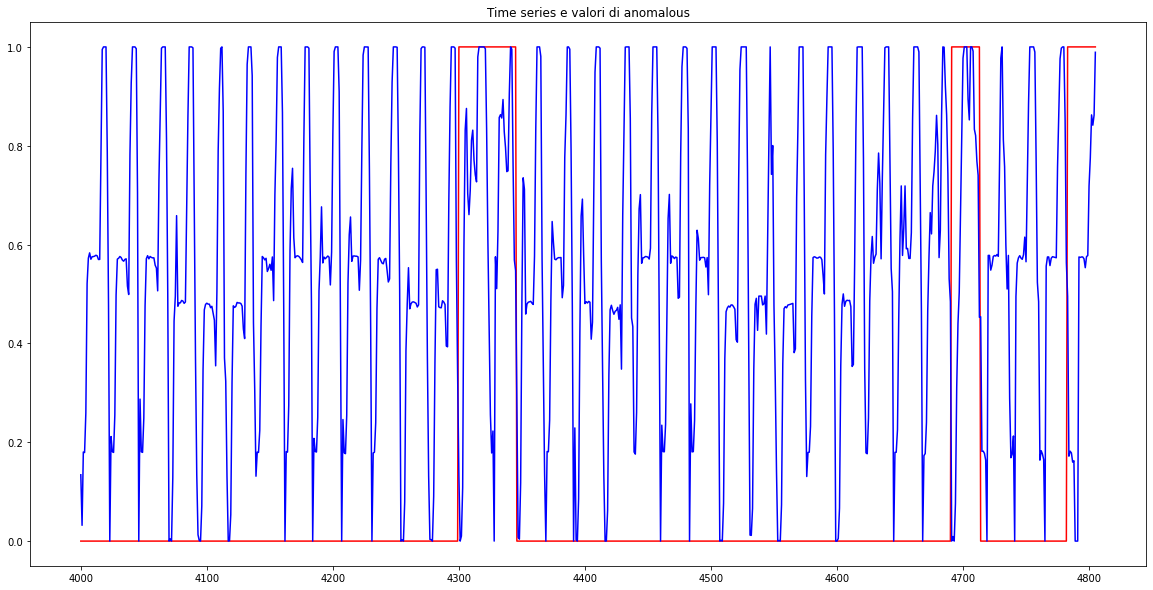

In [6]:
df = df.iloc[4000:]
plt.figure(figsize=(20,10))

plt.title("Time series e valori di anomalous")
plt.plot(df.index,df["Anomalous"],color="r")

plt.plot(df.index,df["Affluenza"],color="b")
plt.show()

Massimo numero di giorno "normali" presenti nel dataset.

In [7]:
df = pd.read_csv("preprocessato.csv")
del df["Unnamed: 0"]

cont = 0
cont_anomalous = 0
tot_days = 0 # debugging
saved = 0

for row in df.itertuples():
  
  if row[3] == 0:
    cont+=1
  else: 
    if cont > saved:
      saved = cont
    cont_anomalous += 1
    tot_days += cont
    cont = 0

tot_days += cont_anomalous
print("Il numero massimo di giorni normali consecutivi è " + str(round(saved/23)) + " ( " + str(saved) + " righe )" + ", mentre i giorni anomali sono: " + str(round(cont_anomalous/23)) + ". I giorni totali sono " + str(round(tot_days/23)))

N = round(saved/23) - 1

Il numero massimo di giorni normali consecutivi è 59 ( 1357 righe ), mentre i giorni anomali sono: 12. I giorni totali sono 209


Plotto le time-series relative alle giornati normali. Negli spazi vuoti ci sono i giorni anomali.

No handles with labels found to put in legend.


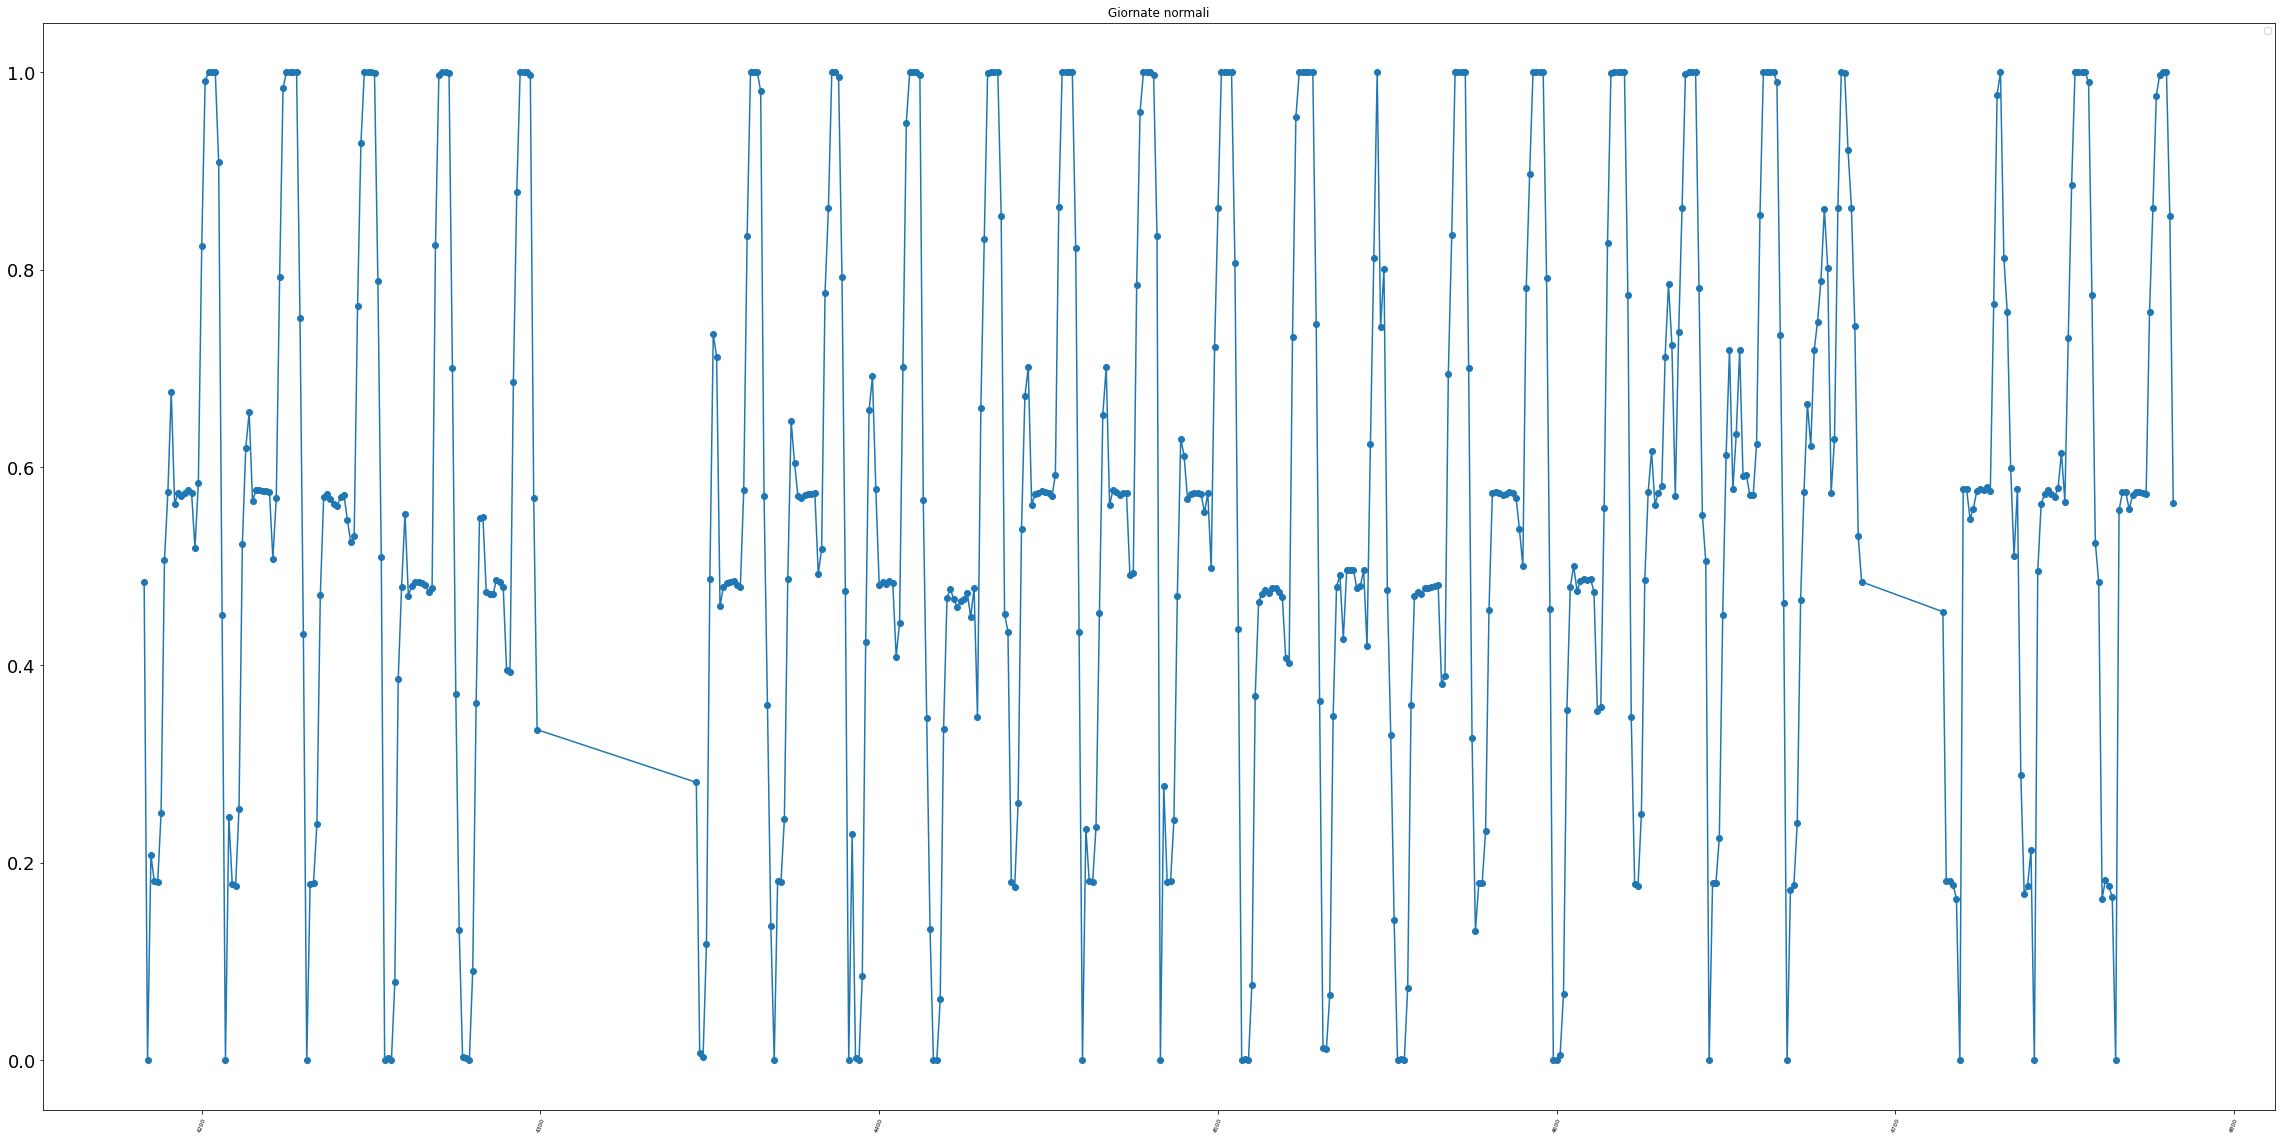

In [8]:
# dataframe con gli N giorni normali precedenti ad un giorno anomalo
giorni_normali = df[df['Anomalous'] == 0 ]
giorni_normali.to_csv("normali.csv")

plt.figure(figsize=(40, 20))
plt.title("Giornate normali")
plt.plot(giorni_normali.iloc[4000:].index, giorni_normali['Affluenza'].iloc[4000:],marker="o")
plt.legend(loc='best', fontsize='small')
plt.xticks(fontsize=6)
plt.yticks(fontsize=18)
plt.xticks(rotation=70)
plt.show()

Plotto le time-series delle giornate anomale.

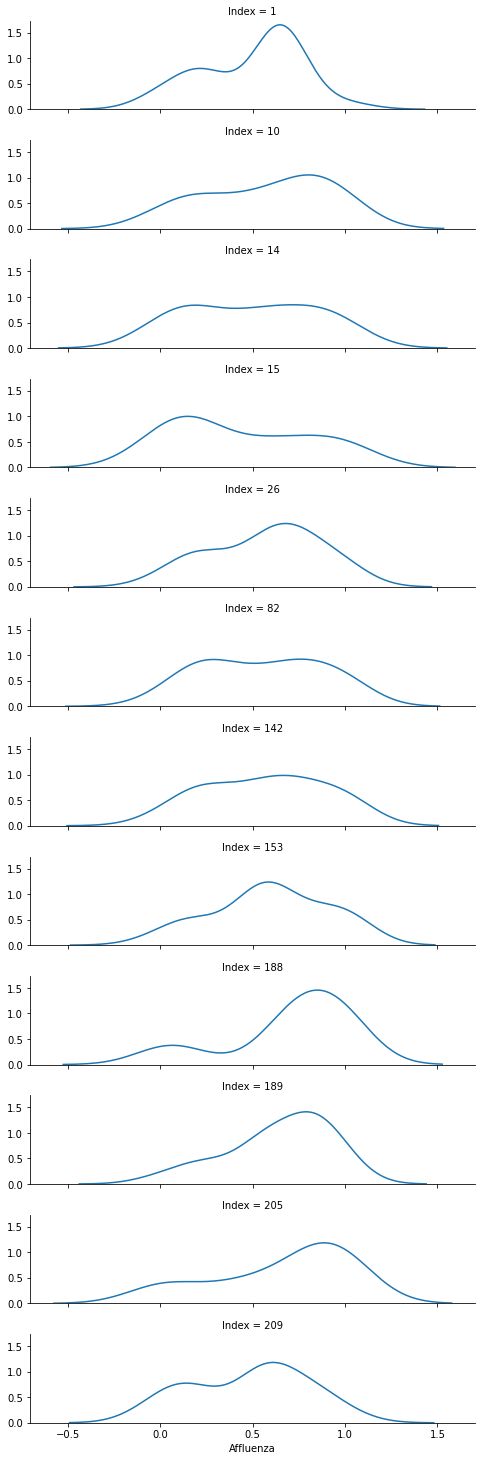

In [9]:
giorni_anomali = df[df['Anomalous'] == 1 ]
giorni_anomali.to_csv("anomali.csv")

df = pd.read_csv("anomali.csv")

g = sns.FacetGrid(df, row="Index", height=1.7, aspect=4,)
g.map(sns.kdeplot, "Affluenza")

Definiamo delle funzioni che ci saranno utili in seguito:

In [10]:
## Trova il dataframe target, ovvero la finestra di N giorni normali che precedono il giorno anomalo passato come parametro

def find_df_target(anomalo) :
  ret = []
  cont = 0
  max = anomalo
  
  # trovo tutti i giorni normali precedenti 
  x = giorni_normali[giorni_normali.index <= anomalo]
  x = pd.DataFrame(x)
  normal_day_before = x.shape[0]

  if normal_day_before < N*23 :
    print("Non c'è margine per la finestra")

  min = normal_day_before - (N-1)*23

  for row in giorni_normali.itertuples():
    if (row[4] > min) & (row[4] < max):
      ret.append(row)
      cont += 1

  return ret

In [11]:
## conteggio dei giorni normali che precedono il giorno anomalo passato per parametro

def find_count_normal_days(anomalo) :
    cont = 0
    quanti = []
    for x in giorni_normali.itertuples():
      if x[0] < anomalo:
        cont+=1
        quanti.append(cont)
      else:
        quanti.append(0)
    
    giorni_normali["Quanti"] = quanti
    return cont

In [12]:
## funzione che effettua la predizione

def prediction(dataset,df,plot_df,row,cont) :
  n_input = 23
  n_features = 1

  # parametri: batch_size=32, epochs = 100
  generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=32)
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
  model.add(Dropout(0.15))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  model.fit(generator, epochs=90)

  pred_list = []
  batch = dataset[-n_input:].reshape((1, n_input, n_features))

  for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

  df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=df_target[-n_input:].index, columns=['Prediction'])
  
  df_anomali = pd.read_csv("anomali.csv")
  anomalia_visualizzata = df_anomali[df_anomali["Index"] == row[1]]
  anomalia_visualizzata.to_csv("giorno_anomalo_mostrato" + str(cont) + ".csv")
  
  plt.figure(figsize=(40, 20))

  plt.subplot(212)
  plt.plot(anomalia_visualizzata.index, anomalia_visualizzata["Affluenza"],marker="o",color = "b")
  plt.plot(anomalia_visualizzata.index, df_predict['Prediction'], color='r', marker="o")
  
  plt.subplot(221)
  plt.title("Predizione")
  plt.plot(df_predict.index, df_predict["Prediction"], color='r', marker="o")
  plt.plot(df.iloc[1100:1400].index,df["Affluenza"].iloc[1100:1400],color = "b",marker="o")
  plt.legend(loc='best', fontsize='small')
  plt.xticks(fontsize=6)
  plt.yticks(fontsize=18)
  plt.xticks(rotation=70)
  
  plt.subplot(222)
  plt.plot(df_predict.index, df_predict['Prediction'], color='r', marker="o")

  plt.grid()
  plt.show()

      Index  Affluenza  Anomalous
0         1   1.000000          1
1         1   0.000000          1
2         1   0.299891          1
3         1   0.195044          1
4         1   0.198812          1
...     ...        ...        ...
4801    209   0.775303          1
4802    209   0.862443          1
4803    209   0.841555          1
4804    209   0.861950          1
4805    209   0.989119          1

[4806 rows x 3 columns]
Epoch 1/90
41/41 [==============================] - 2s 43ms/step - loss: 0.1301
Epoch 2/90
41/41 [==============================] - 2s 43ms/step - loss: 0.0598
Epoch 3/90
41/41 [==============================] - 2s 44ms/step - loss: 0.0331
Epoch 4/90
41/41 [==============================] - 2s 43ms/step - loss: 0.0282
Epoch 5/90
41/41 [==============================] - 2s 44ms/step - loss: 0.0242
Epoch 6/90
41/41 [==============================] - 2s 44ms/step - loss: 0.0186
Epoch 7/90
41/41 [==============================] - 2s 43ms/step - loss: 0.0197
Epoch 8

No handles with labels found to put in legend.


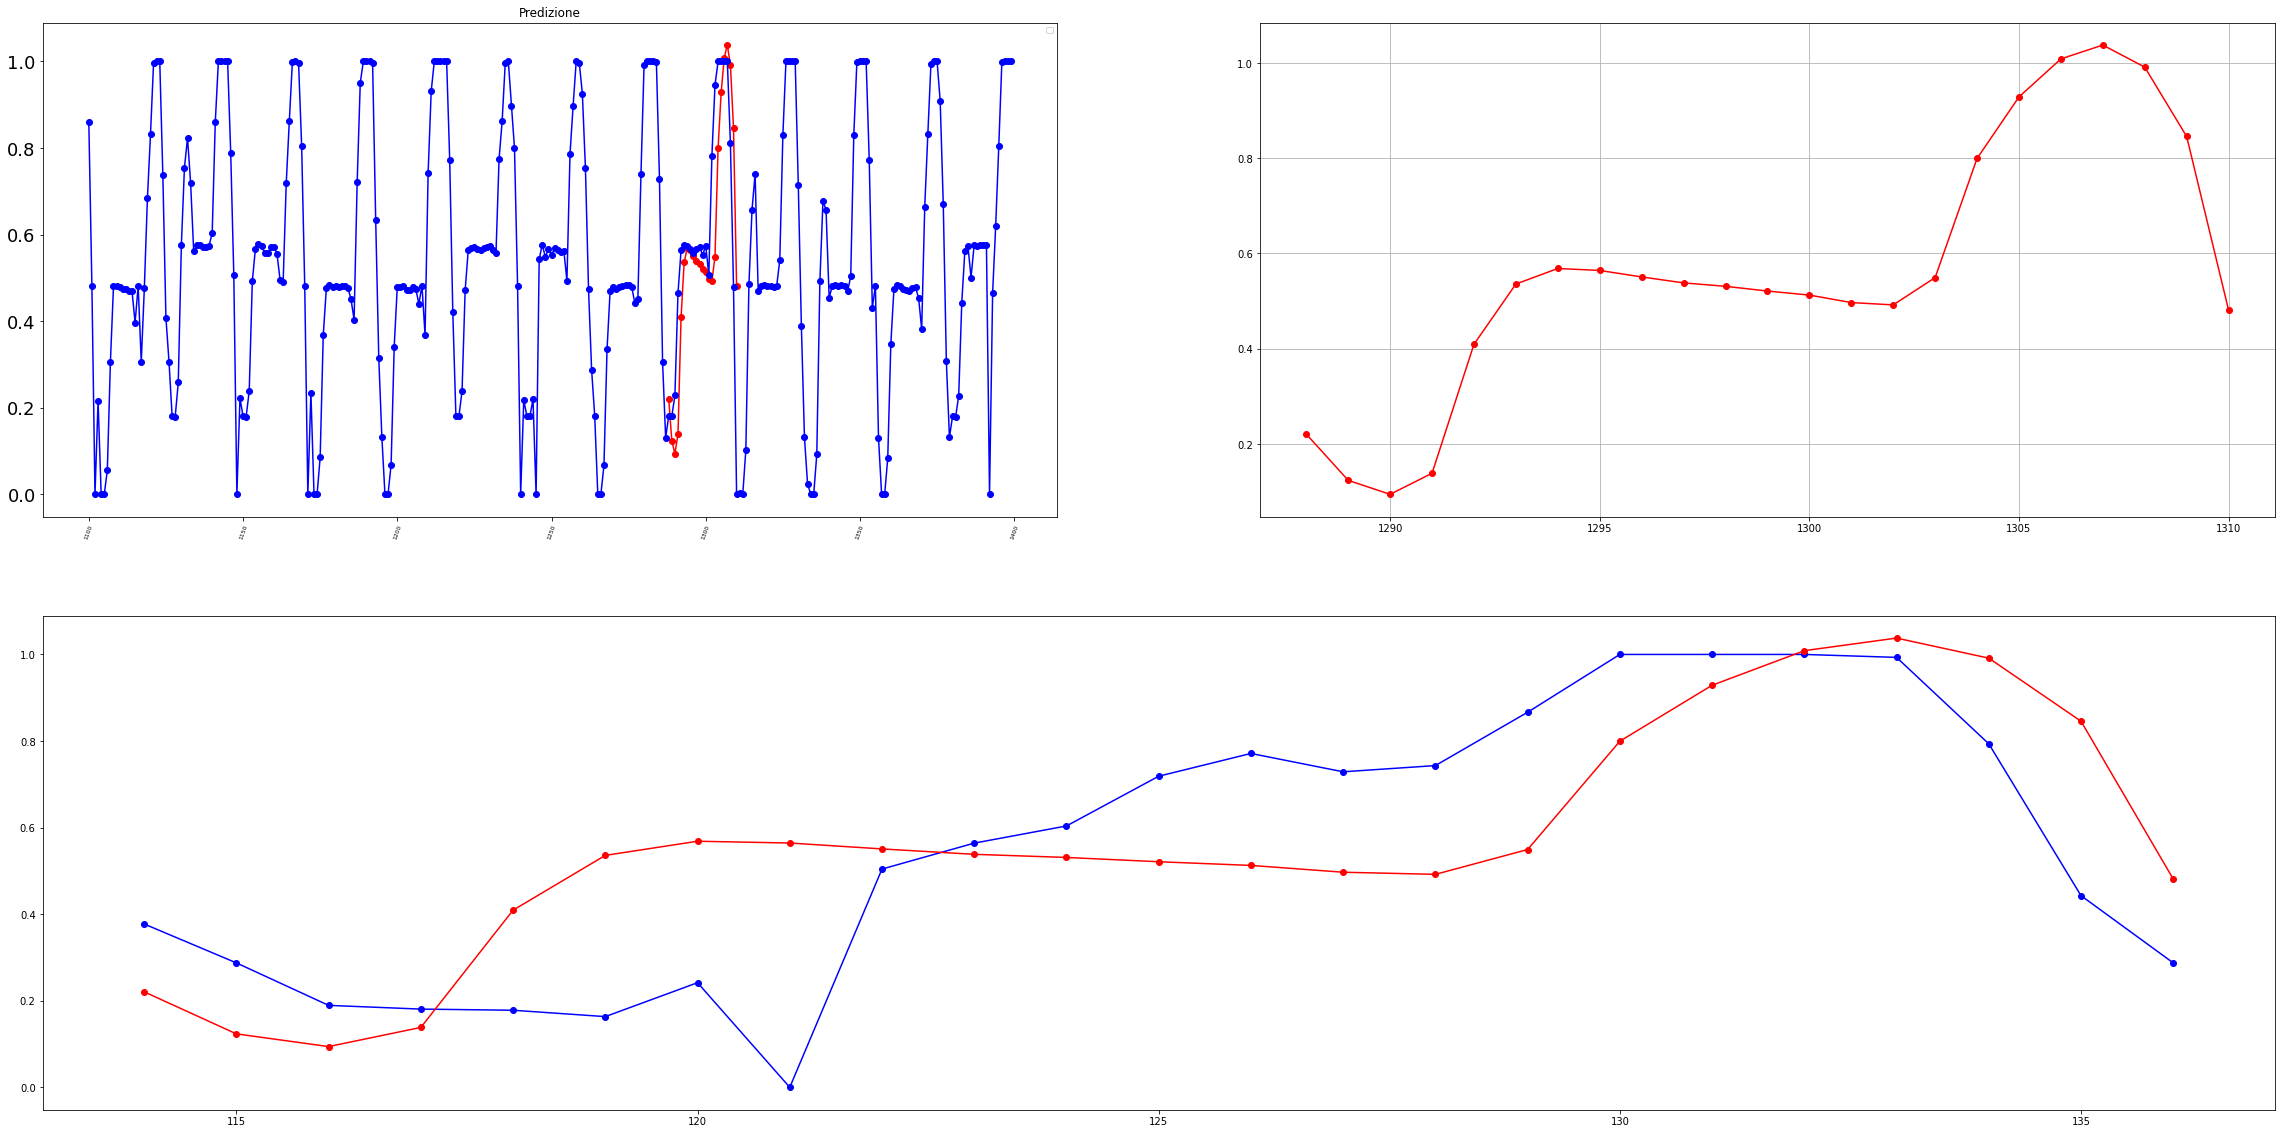

Epoch 1/90
41/41 [==============================] - 2s 50ms/step - loss: 0.1186
Epoch 2/90
41/41 [==============================] - 2s 51ms/step - loss: 0.0467
Epoch 3/90
41/41 [==============================] - 2s 52ms/step - loss: 0.0308
Epoch 4/90
41/41 [==============================] - 2s 50ms/step - loss: 0.0294
Epoch 5/90
41/41 [==============================] - 2s 49ms/step - loss: 0.0257
Epoch 6/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0253
Epoch 7/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0226
Epoch 8/90
41/41 [==============================] - 2s 48ms/step - loss: 0.0212
Epoch 9/90
41/41 [==============================] - 2s 48ms/step - loss: 0.0206
Epoch 10/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0196
Epoch 11/90
41/41 [==============================] - 2s 51ms/step - loss: 0.0203
Epoch 12/90
41/41 [==============================] - 2s 57ms/step - loss: 0.0190
Epoch 13/90
41/41 [==================

No handles with labels found to put in legend.


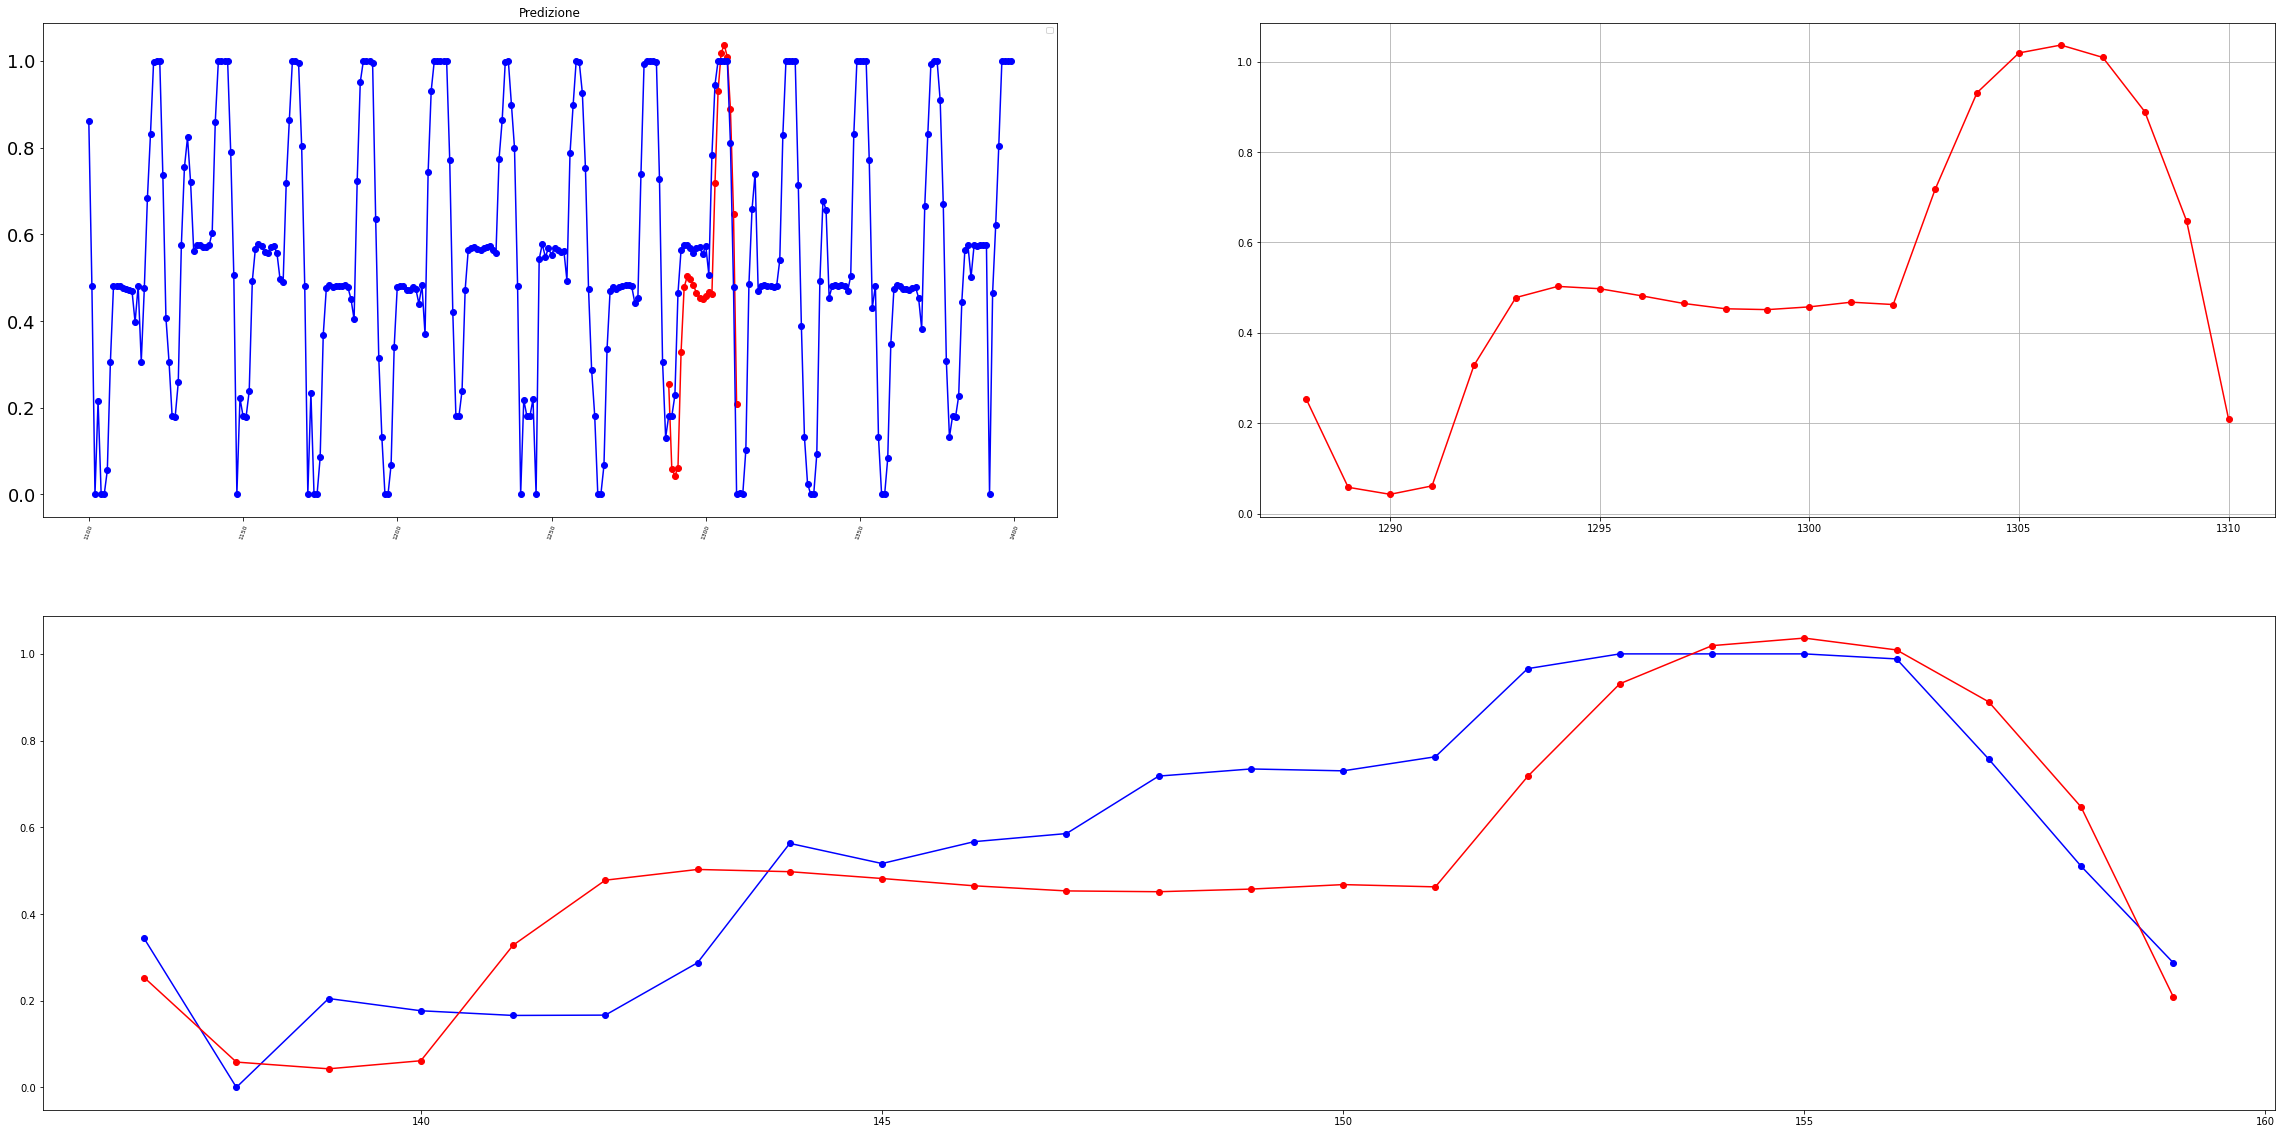

Epoch 1/90
41/41 [==============================] - 2s 48ms/step - loss: 0.1116
Epoch 2/90
41/41 [==============================] - 2s 48ms/step - loss: 0.0491
Epoch 3/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0305
Epoch 4/90
41/41 [==============================] - 2s 48ms/step - loss: 0.0261
Epoch 5/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0232
Epoch 6/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0214
Epoch 7/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0194
Epoch 8/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0181
Epoch 9/90
41/41 [==============================] - 2s 48ms/step - loss: 0.0188
Epoch 10/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0227
Epoch 11/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0185
Epoch 12/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0187
Epoch 13/90
41/41 [==================

No handles with labels found to put in legend.


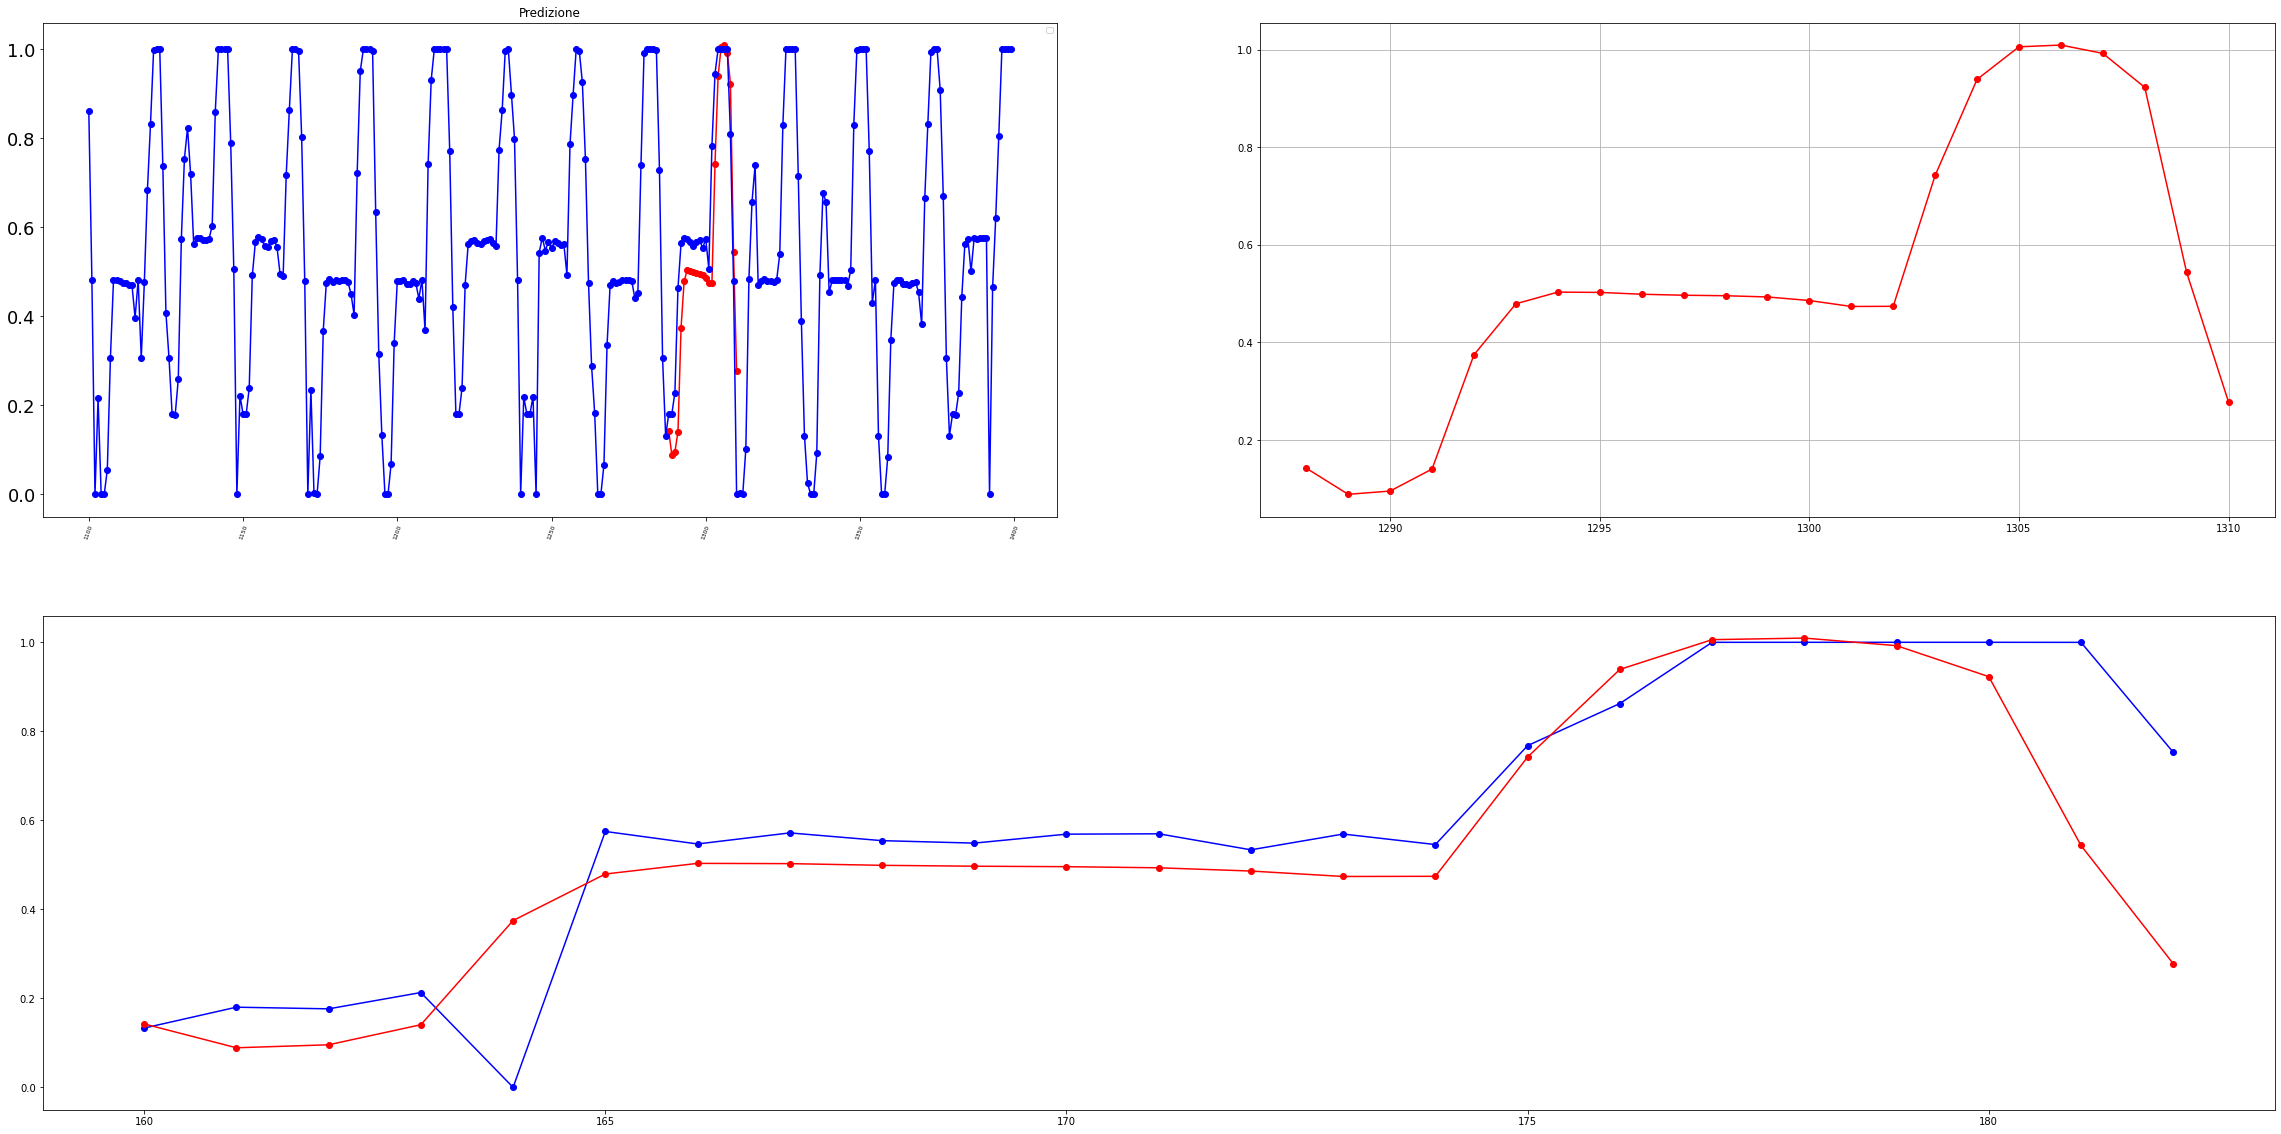

Epoch 1/90
41/41 [==============================] - 2s 49ms/step - loss: 0.0988
Epoch 2/90
41/41 [==============================] - 2s 51ms/step - loss: 0.0561
Epoch 3/90
41/41 [==============================] - 2s 51ms/step - loss: 0.0306
Epoch 4/90
41/41 [==============================] - 2s 51ms/step - loss: 0.0238
Epoch 5/90
41/41 [==============================] - 2s 50ms/step - loss: 0.0192
Epoch 6/90
41/41 [==============================] - 2s 49ms/step - loss: 0.0185
Epoch 7/90
41/41 [==============================] - 2s 49ms/step - loss: 0.0175
Epoch 8/90
41/41 [==============================] - 2s 50ms/step - loss: 0.0163
Epoch 9/90
41/41 [==============================] - 2s 49ms/step - loss: 0.0178
Epoch 10/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0164
Epoch 11/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0156
Epoch 12/90
41/41 [==============================] - 2s 48ms/step - loss: 0.0153
Epoch 13/90
41/41 [==================

No handles with labels found to put in legend.


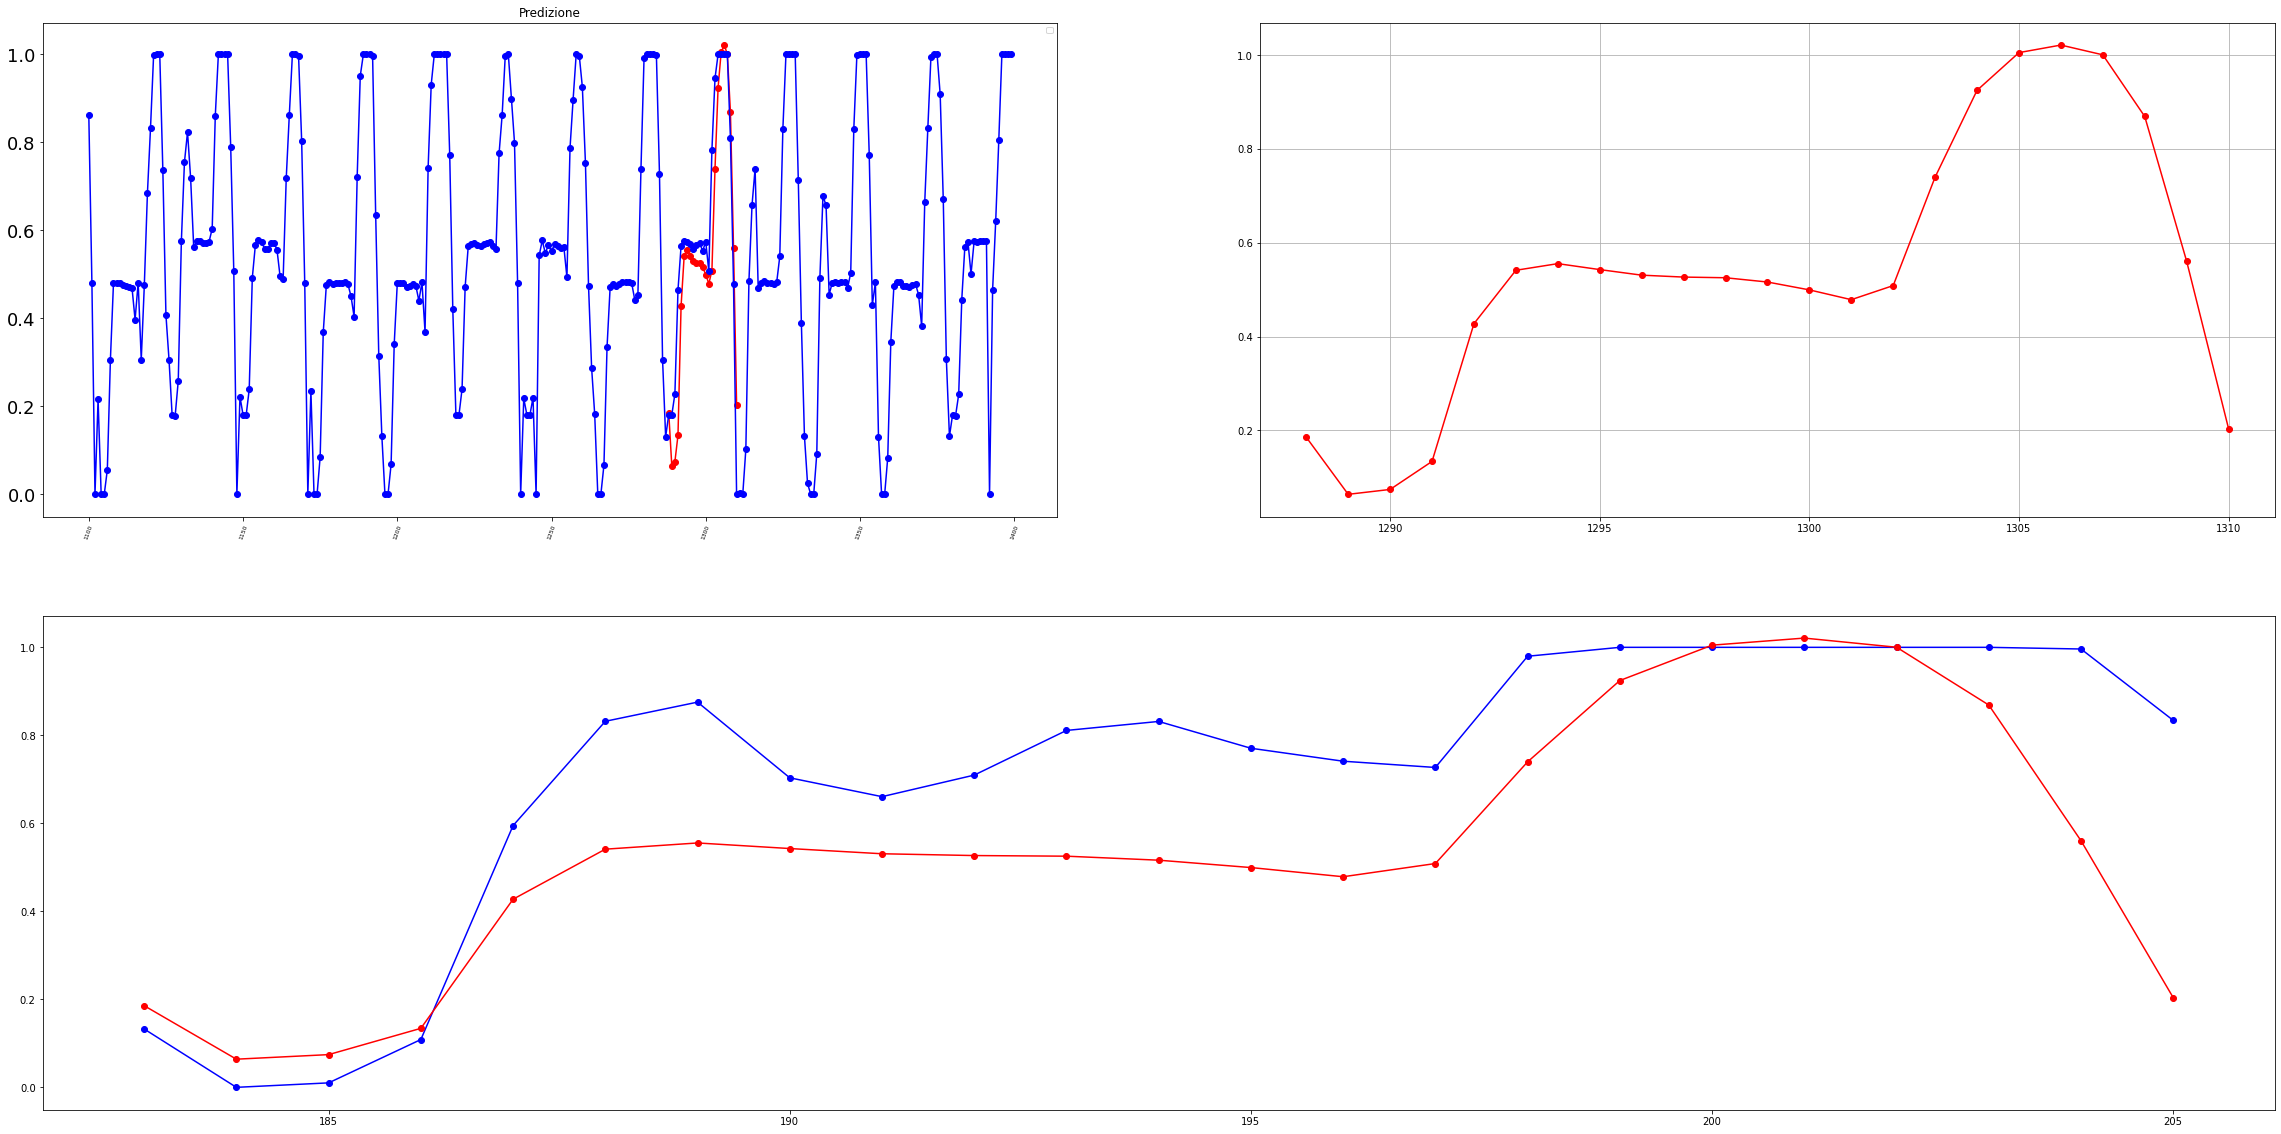

Epoch 1/90
41/41 [==============================] - 2s 47ms/step - loss: 0.1267
Epoch 2/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0685
Epoch 3/90
41/41 [==============================] - 2s 45ms/step - loss: 0.0329
Epoch 4/90
41/41 [==============================] - 2s 45ms/step - loss: 0.0267
Epoch 5/90
41/41 [==============================] - 2s 44ms/step - loss: 0.0201
Epoch 6/90
41/41 [==============================] - 2s 45ms/step - loss: 0.0194
Epoch 7/90
41/41 [==============================] - 2s 45ms/step - loss: 0.0203
Epoch 8/90
41/41 [==============================] - 2s 45ms/step - loss: 0.0177
Epoch 9/90
41/41 [==============================] - 2s 45ms/step - loss: 0.0185
Epoch 10/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0172
Epoch 11/90
41/41 [==============================] - 2s 51ms/step - loss: 0.0155
Epoch 12/90
41/41 [==============================] - 2s 51ms/step - loss: 0.0166
Epoch 13/90
41/41 [==================

No handles with labels found to put in legend.


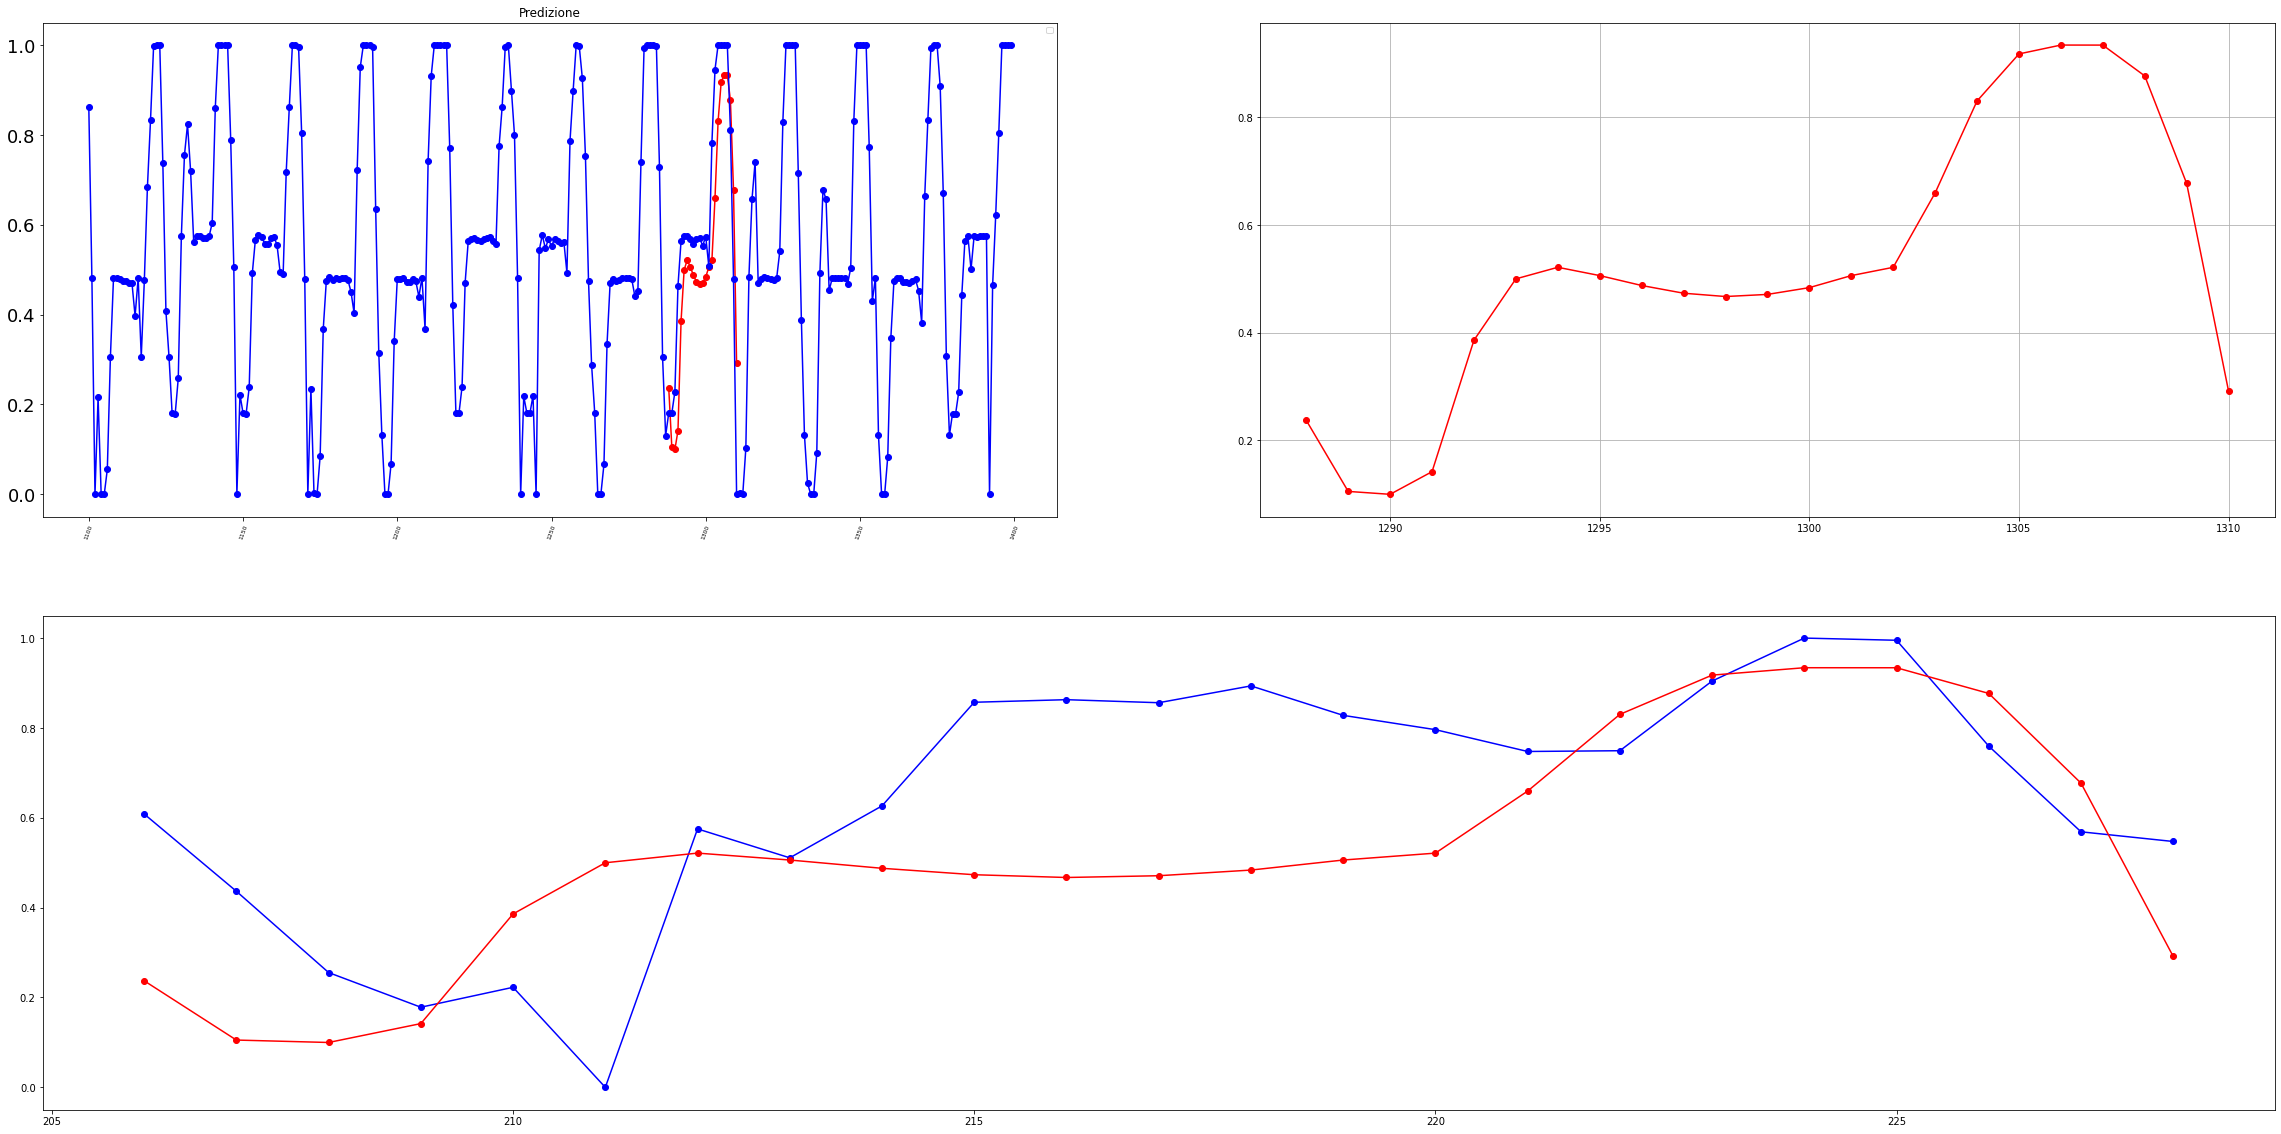

Epoch 1/90
41/41 [==============================] - 2s 45ms/step - loss: 0.1195
Epoch 2/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0633
Epoch 3/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0329
Epoch 4/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0257
Epoch 5/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0236
Epoch 6/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0189
Epoch 7/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0182
Epoch 8/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0188
Epoch 9/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0174
Epoch 10/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0185
Epoch 11/90
41/41 [==============================] - 2s 45ms/step - loss: 0.0172
Epoch 12/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0193
Epoch 13/90
41/41 [==================

No handles with labels found to put in legend.


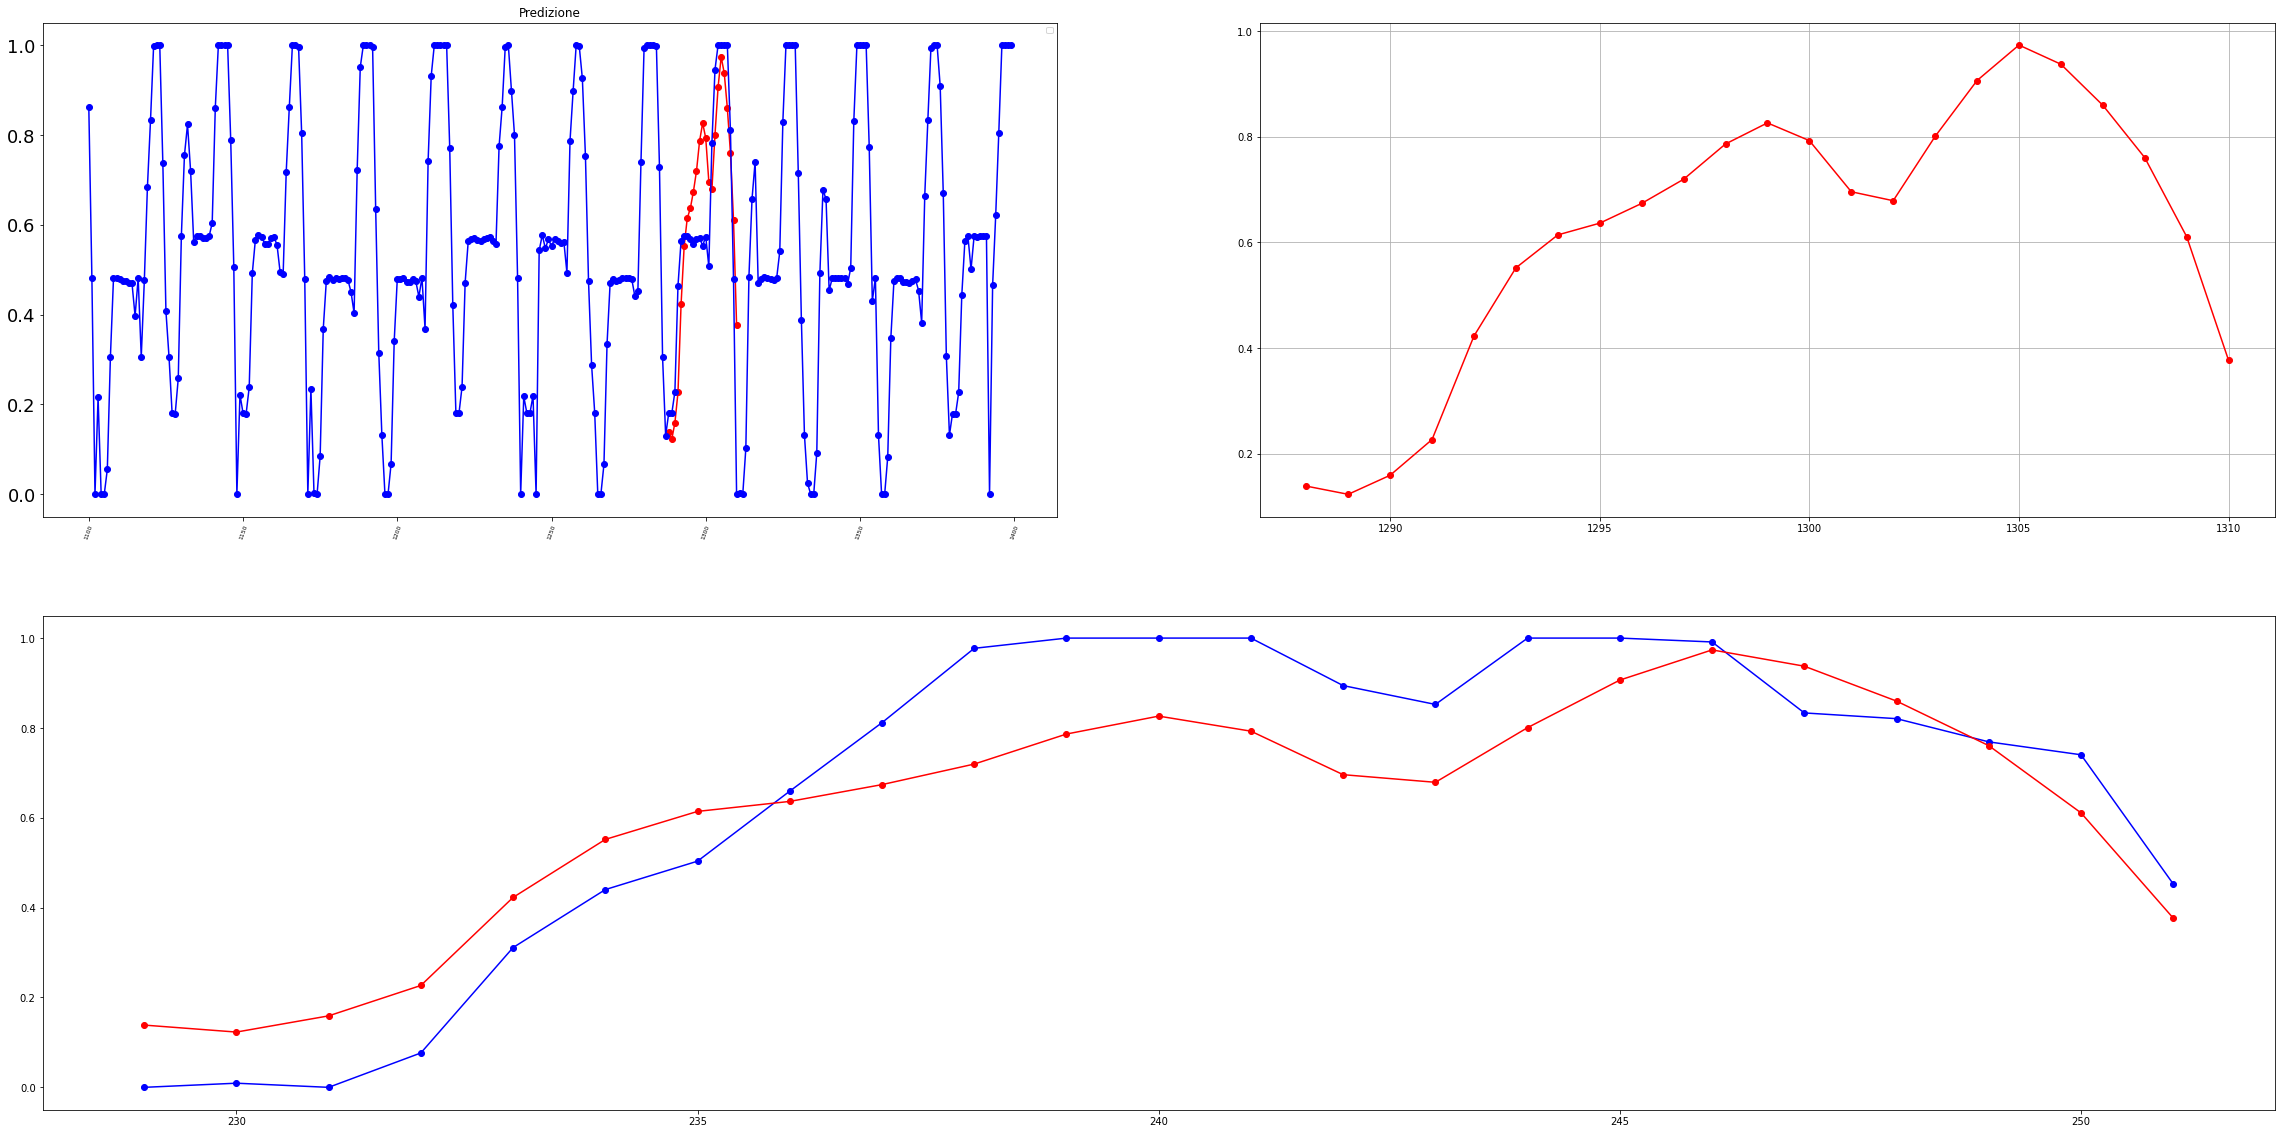

Epoch 1/90
41/41 [==============================] - 2s 46ms/step - loss: 0.1147
Epoch 2/90
41/41 [==============================] - 2s 48ms/step - loss: 0.0528
Epoch 3/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0312
Epoch 4/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0213
Epoch 5/90
41/41 [==============================] - 2s 47ms/step - loss: 0.0222
Epoch 6/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0183
Epoch 7/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0179
Epoch 8/90
41/41 [==============================] - 2s 44ms/step - loss: 0.0177
Epoch 9/90
41/41 [==============================] - 2s 45ms/step - loss: 0.0177
Epoch 10/90
41/41 [==============================] - 2s 45ms/step - loss: 0.0195
Epoch 11/90
41/41 [==============================] - 2s 45ms/step - loss: 0.0198
Epoch 12/90
41/41 [==============================] - 2s 46ms/step - loss: 0.0169
Epoch 13/90
41/41 [==================

No handles with labels found to put in legend.


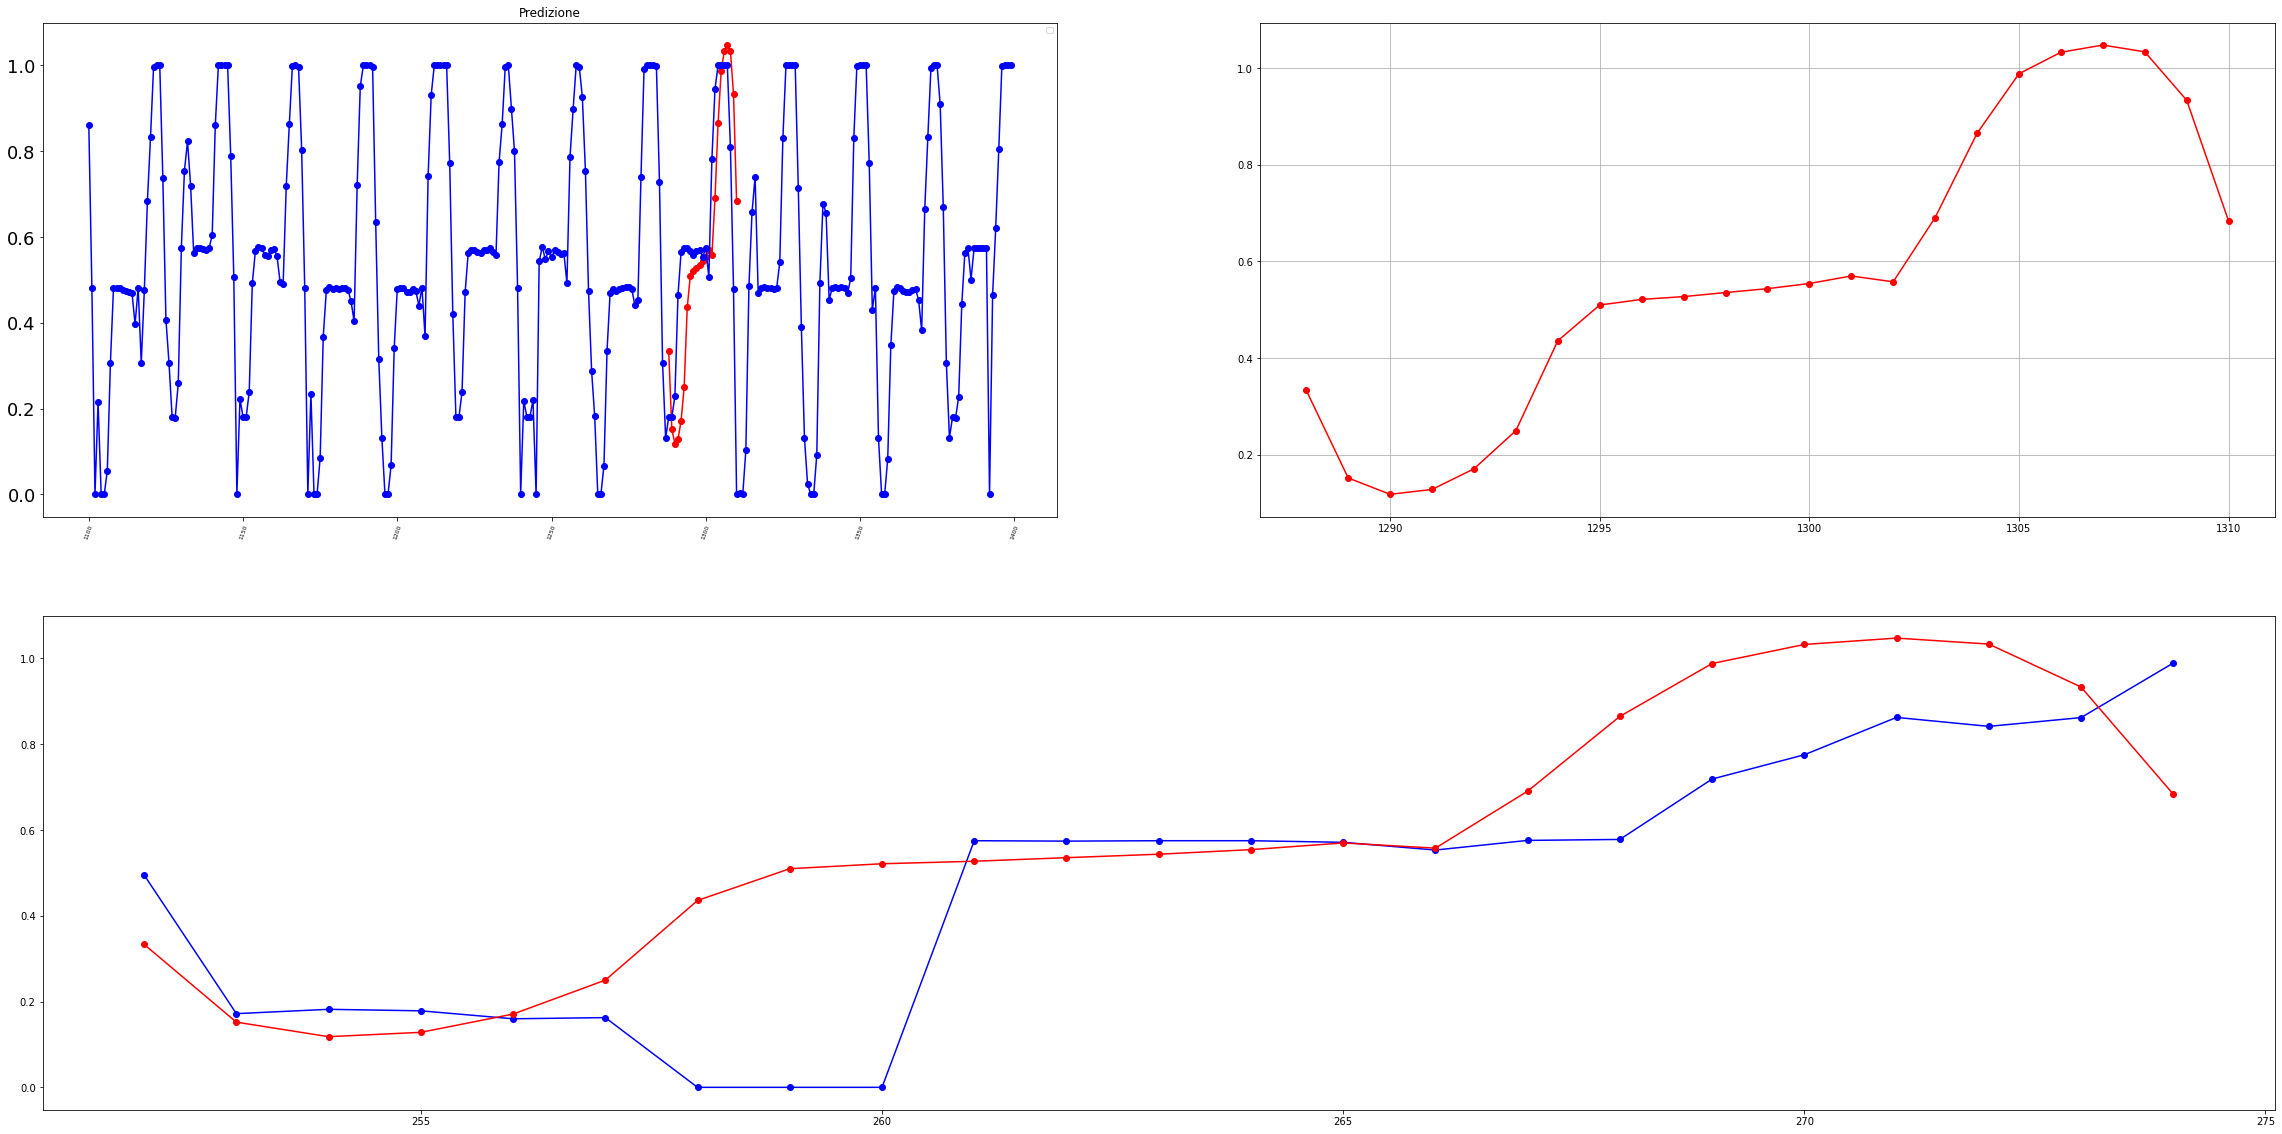

In [16]:
df = pd.read_csv("preprocessato.csv")
del df["Unnamed: 0"]

controllati = []
skip = False

for row in df.itertuples():
  # condizione: giorno anomalo e posso creare una finestra di N giorni
  x = find_count_normal_days(row[0])
  if (row[3] == 1) & (x >= N*23): 

    for i in range(len(controllati)): 
      if controllati[i] == row[1]:
        skip = True  
        break

    if skip == False:
      df_target = find_df_target(row[0])
      df_target = pd.DataFrame(df_target)
      df_target.to_csv("target.csv")

      ## tolgo le colonne che non servono al momento
      del df_target["Index"]
      del df_target["_1"]
      del df_target["Anomalous"]
      del df_target["Quanti"]

      controllati.append(row[1])

      train = df_target
      scaler = MinMaxScaler()
      scaler.fit(train)
      train = scaler.transform(train)

      prediction(train,df,df_target,row,cont)
    
    skip = False

    ## break ## decommentare se si vuole vedere soltanto la prima iterazione
